#Installing and Importing Packages

In [ ]:
!pip install dwave.system
!pip install dwave.cloud
!pip install dwave.samplers

In [41]:
import numpy as np
from collections import defaultdict
from dimod import SimulatedAnnealingSampler
import random
import time
import networkx as nx
import matplotlib.pyplot as plt
from bokeh.palettes import Spectral
from collections import defaultdict
from math import floor

# Постановка задачи
Есть n предметов и рюкзак, вместимоси capacity. У каждого есть вес и стоимость. Наша задача - максимизировать стоимость предметов, при этом не превосходя capacity.

#Brute Force - полный перебор решений
Асимптотика O($2^N$), где N - число предметов

In [42]:
items_values = {"⚽️": 8, "💻": 47, "📸": 10, "📚": 5, "🎸": 16}
values_list = [8, 47, 10, 5, 16]

items_weight = {"⚽️": 3, "💻": 11, "📸": 14, "📚": 19, "🎸": 5}
weights_list = [3, 11, 14, 19, 5]

maximum_weight = 26

items_values = {"⚽️": 10, "💻": 10, "📸": 10, "📚": 10, "🎸": 10}

In [43]:
def sum_weight(bitstring, items_weight):
    weight = 0
    for n, i in enumerate(items_weight):
        if bitstring[n] == "1":
            weight += i
    return weight


def sum_values(bitstring, items_value):
    value = 0
    for n, i in enumerate(items_value):
        if bitstring[n] == "1":
            value += i
    return value

items = list(items_values.keys())
n_items = len(items)
combinations = {}
max_value = 0
for case_i in range(2**n_items):  # all possible options
    combinations[case_i] = {}
    bitstring = np.binary_repr(
        case_i, n_items
    )  # bitstring representation of a possible combination, e.g, "01100" in our problem means bringing (-💻📸--)
    combinations[case_i]["items"] = [items[n] for n, i in enumerate(bitstring) if i == "1"]
    combinations[case_i]["value"] = sum_values(bitstring, values_list)
    combinations[case_i]["weight"] = sum_values(bitstring, weights_list)
    # save the information of the optimal solution (the one that maximizes the value while respecting the maximum weight)
    if (
        combinations[case_i]["value"] > max_value
        and combinations[case_i]["weight"] <= maximum_weight
    ):
        max_value = combinations[case_i]["value"]
        optimal_solution = {
            "items": combinations[case_i]["items"],
            "value": combinations[case_i]["value"],
            "weight": combinations[case_i]["weight"],
        }


print(
    f"The best combination is {optimal_solution['items']} with a total value: {optimal_solution['value']} and total weight {optimal_solution['weight']} "
)

The best combination is ['⚽️', '💻', '🎸'] with a total value: 71 and total weight 19 


# DP Soluton
решение, использующее динамическое программирование.

Асимптотика O(СN), где С - capacity, N - количество предметов

(все веса действительные неотрицательные)

In [44]:
def dp_solution(costs, weights, capacity):
    num_of_items = len(weights)
    dp = [[0 for x in range(capacity + 1)] for x in range(num_of_items + 1)]

    for i in range(num_of_items + 1):
        for weight in range(capacity + 1):
            if i == 0 or weight == 0:
                dp[i][weight] = 0
            elif weights[i - 1] <= weight:
                dp[i][weight] = max(costs[i-1]
                            + dp[i - 1][weight - weights[i-1]],
                            dp[i - 1][weight])
            else:
                dp[i][weight] = dp[i - 1][weight]

    cur_item = num_of_items
    cur_weight = capacity
    used_items = [0 for i in range(num_of_items)]
    while (cur_item != 0 and cur_weight != 0):
        if (dp[cur_item - 1][cur_weight] == dp[cur_item][cur_weight]):
            cur_item -= 1;
        else:
            cur_weight -= weights[cur_item - 1]
            used_items[cur_item - 1] = 1;
            cur_item -= 1;

    return used_items

#QUBO Solution
Решение, использующее матрицу QUBO

In [45]:
def make_qubo(costs, weights, max_weight):
    q = defaultdict(int)
    hyper_parameter = 2

    for i in range(len(weights)):
        if i < len(costs):
            q[(i, i)] += hyper_parameter * weights[i] * (weights[i] - 2 * max_weight) - costs[i]
        else:
            q[(i, i)] += hyper_parameter * weights[i] * (weights[i] - 2 * max_weight)

        for j in range(i + 1, len(weights)):
            q[(i, j)] += 2 * hyper_parameter * weights[i] * weights[j]

    # lambd = 2
    # for i in range(len(weights)):
    #     q[(i, i)] += lambd * weights[i] * (weights[i] - 2 * maximum_weight)  # Eq. 10
    #     for j in range(i + 1, len(weights)):
    #         q[(i, j)] += 2 * lambd * weights[i] * weights[j]
    return q

def qubo_solution(costs, weights, max_weight):
    q = make_qubo(costs, weights, max_weight)

    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(q)

    ans = sampleset.first.sample
    ans_array = [ans[i] for i in range(len(costs))]
    ans_weight = sum([ans_array[i] * weights[i] for i in range(len(costs))])
    ans_cost = sum([ans_array[i] * costs[i] for i in range(len(costs))])

    return ans_array

# Utils

In [46]:
def timer(ret=False):
    def wrapper(func):
        def wrapped(*args):
            start_time = time.perf_counter_ns()
            res = func(*args)
            ms = (time.perf_counter_ns() - start_time) * 1e-6

            if ret:
                return res, ms
            print(ms, "ms")

            return res

        return wrapped

    return wrapper

In [47]:
def get_result(costs, weights, used_items):
    used_weight = sum([weights[i] * used_items[i] for i in range(len(weights))])
    cost = sum([costs[i] * used_items[i] for i in range(len(weights))])
    return used_weight, cost

# Тесты

In [48]:
"""
Пример теста:
8 47 10 5 16
3 11 14 19 5
26
"""

costs = list(map(int, input().split()))
weights = list(map(int, input().split()))
capacity = int(input())

8 47 10 5 16
3 11 14 19 5
26


In [49]:
costs = [207678, 199724, 247909, 60785, 49306, 272482, 543, 290570, 328346]
weights = [332860, 290562, 286955, 109302, 300472, 244507, 233919, 208000, 226560]
capacity = 1221516

In [50]:
bin_ans, time_ = timer(True)(qubo_solution)(costs, weights, capacity)

In [51]:
print(bin_ans)
time_

[0, 0, 0, 0, 1, 1, 1, 1, 1]


1315.848389

In [52]:
get_result(costs, weights, bin_ans)

(1213458, 941247)

In [53]:
bin_ans, time_ = timer(True)(dp_solution)(costs, weights, capacity)

In [54]:
print(bin_ans)
time_

[0, 0, 1, 1, 0, 1, 0, 1, 1]


10189.258065

In [55]:
get_result(costs, weights, bin_ans)

(1075324, 1200092)

In [56]:
costs = [1, 3, 1]
weights = [2, 2, 2]
capacity = 3

In [57]:
dp_solution(costs, weights, capacity)

[0, 1, 0]

In [65]:
dp_answers = []
qubo_answers = []
capacities = []
def tests():
    for num_of_items in range(1, 20):
        num_of_tests = 1
        qubo_time = 0
        dp_time = 0

        num_cap = 1000000
        for test in range(num_of_tests):
            costs = [random.randint(1, floor(num_cap / 2)) for i in range(num_of_items)]
            weights = [random.randint(1, floor(num_cap / 2)) for i in range(num_of_items)]
            capacity = random.randint(num_cap, 3 * num_cap)
            dp_ans, time_ = timer(True)(dp_solution)(weights, costs, capacity)
            dp_time += time_

            dp_answers.append([[get_result(costs, weights, dp_ans)], time_]);

            qubo_ans, time_ = timer(True)(qubo_solution)(costs, weights, capacity)
            qubo_time += time_

            qubo_answers.append([[get_result(costs, weights, qubo_ans)], time_]);

            capacities.append(capacity)

            weight_sum, _ = get_result(costs, weights, dp_ans)
            if (capacity < weight_sum):
                print(costs, weights, capacity)


    return dp_answers, qubo_answers
        # accuracy /= num_of_tests
        # print(num_of_items, accuracy, "qubo_time = ", qubo_time, "dp_time = ", dp_time)

In [66]:
tests()

[344921, 76554, 221806, 342337, 474114, 239894, 426034, 103110, 48848] [123510, 418448, 217337, 420002, 85947, 364058, 368940, 205214, 325802] 1062149
[28761, 342482, 487125, 436930, 487891, 352945, 74892, 295590, 18246, 304591, 130852] [477054, 43409, 466604, 387246, 388398, 256497, 231828, 162580, 142714, 277559, 268406] 1794351
[21033, 321538, 113636, 43571, 165661, 235239, 497985, 227039, 430324, 15043, 333270, 351170] [396461, 302243, 431487, 438763, 211784, 217128, 263283, 490138, 443284, 242446, 21681, 21408] 2172779
[121238, 320063, 419876, 3116, 85808, 267285, 37446, 16406, 427500, 254887, 328403, 475185, 206800] [394364, 350752, 53846, 311910, 171075, 44090, 247381, 414729, 50284, 27831, 342196, 409561, 178532] 1606375
[453182, 462109, 122860, 82369, 58239, 413838, 25914, 25838, 482275, 67615, 490309, 176442, 452697, 348820] [38057, 122425, 133722, 164138, 469564, 82205, 438378, 77009, 140004, 366937, 292984, 385008, 403257, 236142] 1482159
[112792, 196951, 136959, 241378, 40

([[[(20045, 13048)], 2047.676356],
  [[(407606, 617694)], 4158.072042],
  [[(1032846, 532467)], 6551.070079],
  [[(1192427, 1412222)], 6145.440578],
  [[(1370819, 1370933)], 9680.108725],
  [[(1143123, 1072088)], 11434.7784],
  [[(1870397, 2010744)], 13391.390932999999],
  [[(1941982, 1908291)], 13359.077846],
  [[(1950861, 1032549)], 7157.1350729999995],
  [[(2214737, 2041499)], 15401.776608],
  [[(2413991, 1776987)], 13327.390255],
  [[(3437017, 2071069)], 18896.911702999998],
  [[(2820500, 1594465)], 13841.836956],
  [[(2674155, 1360794)], 13504.370165],
  [[(2544687, 2153723)], 23019.29658],
  [[(2989233, 2053375)], 23930.412224],
  [[(3822047, 2842153)], 33929.922342],
  [[(3424702, 2170957)], 28118.027088],
  [[(2655838, 1745055)], 22393.493975999998]],
 [[[(20045, 13048)], 45.403503],
  [[(407606, 617694)], 51.003094],
  [[(1032846, 532467)], 88.028408],
  [[(1192427, 1412222)], 143.867282],
  [[(1370819, 1370933)], 207.05149699999998],
  [[(1143123, 1072088)], 268.78877],
  [[(

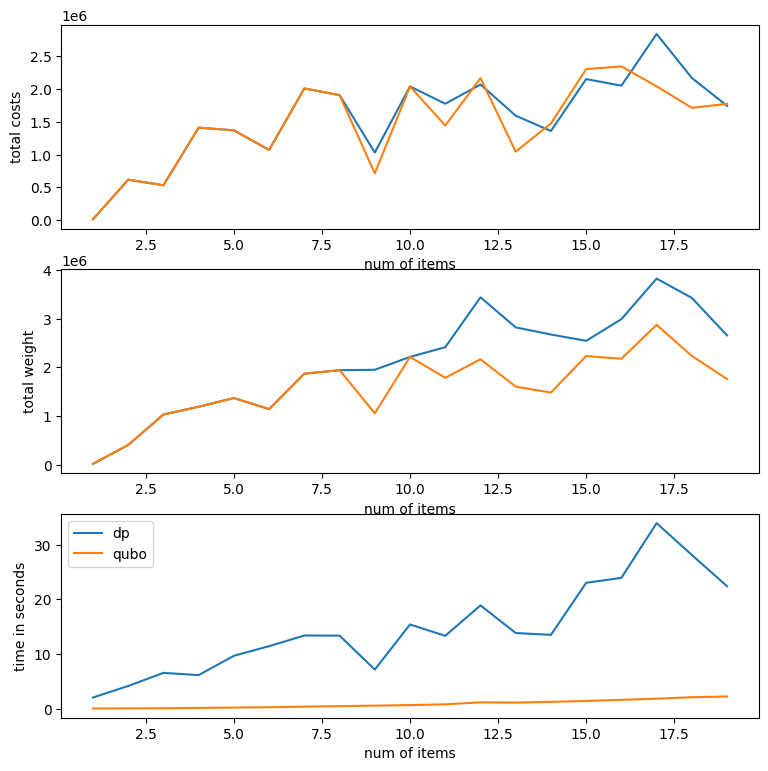

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9))

num_of_items = [i for i in range(1, len(dp_answers) + 1)]

#costs
dp_costs = [dp_answers[i][0][0][1] for i in range(len(dp_answers))]
qubo_costs = [qubo_answers[i][0][0][1] for i in range(len(qubo_answers))]

ax1.plot(num_of_items, dp_costs, label="dp")
ax1.plot(num_of_items, qubo_costs, label="qubo")

ax1.set_ylabel("total costs")
ax1.set_xlabel("num of items")

#weights
dp_weights = [dp_answers[i][0][0][0] for i in range(len(dp_answers))]
qubo_weights = [qubo_answers[i][0][0][0] for i in range(len(qubo_answers))]

ax2.plot(num_of_items, dp_weights, label="dp")
ax2.plot(num_of_items, qubo_weights, label="qubo")
# ax2.scatter(num_of_items, capacities, label="capacity", marker = 'o', color="red")

ax2.set_ylabel("total weight")
ax2.set_xlabel("num of items")

#time
dp_time = [dp_answers[i][1] / 1000 for i in range(len(dp_answers))]
qubo_time = [qubo_answers[i][1] / 1000 for i in range(len(qubo_answers))]

ax3.plot(num_of_items, dp_time, label="dp")
ax3.plot(num_of_items, qubo_time, label="qubo")

ax3.set_ylabel("time in seconds")
ax3.set_xlabel("num of items")

plt.legend()
plt.show()